# COMP7103C Project: Genre-Enhanced Item-Based Collaborative Filtering

**Group**: WANG Siran (3036654364), WEN Yuxuan (3036653956)  
**Goal**: Build a movie recommender using *project-based collaborative filtering* — i.e., item-based CF where similarity is computed **based on movie genres**.

✅ Fully reproducible in Python  
✅ Follows all steps in the proposal


In [ ]:
# Install required packages (uncomment if needed)
# !pip install pandas numpy scikit-learn matplotlib seaborn

In [2]:
!pip install seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set(font_scale=0.9)

## 1. Load and Inspect Dataset

In [6]:
import pandas as pd
import os

# 设置相对路径
DATA_DIR = './ml-latest-small'

# 正确读取数据
movies = pd.read_csv(os.path.join(DATA_DIR, 'movies.csv'))
ratings = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'))

print("movies.csv loaded:")
print(movies.head(3))

print("\n ratings.csv loaded:")
print(ratings.head(3))

print(f"\n Dataset shapes:")
print(f"Movies: {movies.shape}")
print(f"Ratings: {ratings.shape}")


movies.csv loaded:
   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  

 ratings.csv loaded:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224

 Dataset shapes:
Movies: (9742, 3)
Ratings: (100836, 4)


## 2. Data Preprocessing & EDA

In [17]:
# One-hot encode genres (Proposal: "perform one-hot encoding on movie genres")
genres_dummies = movies['genres'].str.get_dummies(sep='|')
movies_encoded = pd.concat([movies[['movieId', 'title']], genres_dummies], axis=1)

# Optional: clean title (remove year in parentheses for display)
import re
movies_encoded['clean_title'] = movies_encoded['title'].str.replace(r'\s*\(\d{4}\)$', '', regex=True)

print("Genre one-hot encoding completed. First 3 rows:")
movies_encoded.head(3)

Genre one-hot encoding completed. First 3 rows:


,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,clean_title
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,Toy Story
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Jumanji
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,Grumpier Old Men


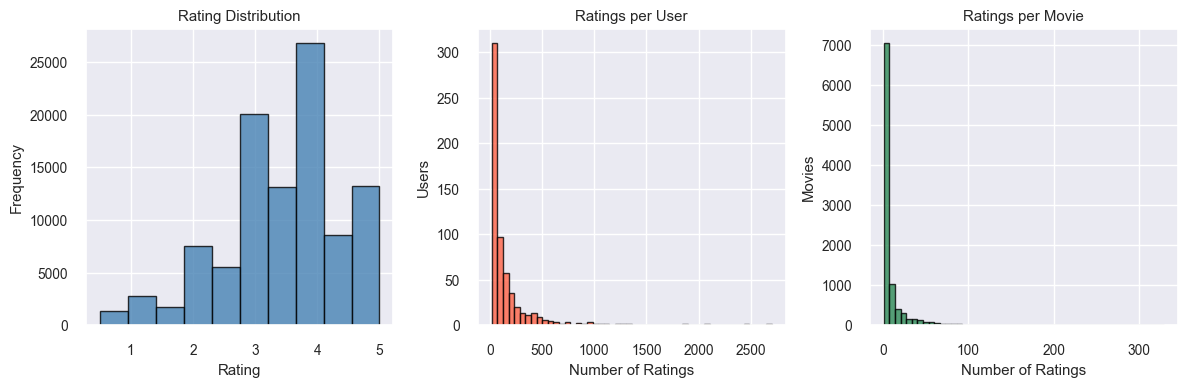

In [18]:
# EDA: Distribution of ratings
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
ratings['rating'].hist(bins=10, color='steelblue', edgecolor='black', alpha=0.8)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
user_counts = ratings['userId'].value_counts()
plt.hist(user_counts, bins=50, color='tomato', edgecolor='black', alpha=0.8)
plt.title('Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Users')

plt.subplot(1, 3, 3)
movie_counts = ratings['movieId'].value_counts()
plt.hist(movie_counts, bins=50, color='seagreen', edgecolor='black', alpha=0.8)
plt.title('Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Movies')

plt.tight_layout()
plt.show()

In [19]:
# Filter users/movies (Proposal: "set thresholds to filter useful data")
min_ratings_user = 20
min_ratings_movie = 10

active_users = user_counts[user_counts >= min_ratings_user].index
popular_movies = movie_counts[movie_counts >= min_ratings_movie].index

filtered_ratings = ratings[
    (ratings['userId'].isin(active_users)) & 
    (ratings['movieId'].isin(popular_movies))
]

print(f"Before filtering: {len(ratings)} ratings")
print(f"After filtering: {len(filtered_ratings)} ratings")
print(f"→ Retained {len(filtered_ratings)/len(ratings)*100:.1f}% of original data")

Before filtering: 100836 ratings
After filtering: 81116 ratings
→ Retained 80.4% of original data


## 3. Build Genre-Based Item Similarity Matrix

In [20]:
# Extract genre feature matrix (n_movies × n_genres)
genre_features = movies_encoded.set_index('movieId').drop(columns=['title', 'clean_title'])

# Align with filtered movies only
genre_features = genre_features.loc[popular_movies].copy()

# Compute cosine similarity between movies **based on genres**
genre_sim_matrix = cosine_similarity(genre_features)
genre_sim_df = pd.DataFrame(
    genre_sim_matrix,
    index=genre_features.index,
    columns=genre_features.index
)

print("Genre-based similarity matrix shape:", genre_sim_df.shape)
print("Top-5 most similar movies to 'Toy Story (1995)':")

# Example: find most similar to Toy Story (movieId=1 in ml-100k)
toy_story_id = 1
if toy_story_id in genre_sim_df.index:
    sim_to_toy = genre_sim_df.loc[toy_story_id].sort_values(ascending=False)[1:6]
    
    # Get genre features (one-hot) for top similar movies
    top_movies_genre_feat = genre_features.loc[sim_to_toy.index]
    top_movies_genre_feat['similarity'] = sim_to_toy.values
    display(top_movies_genre_feat)

Genre-based similarity matrix shape: (2269, 2269)
Top-5 most similar movies to 'Toy Story (1995)':


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,similarity
movieId,,,,,,,,,,,,,,,,,,,,,
166461,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
2294,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
4016,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
3114,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
53121,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0


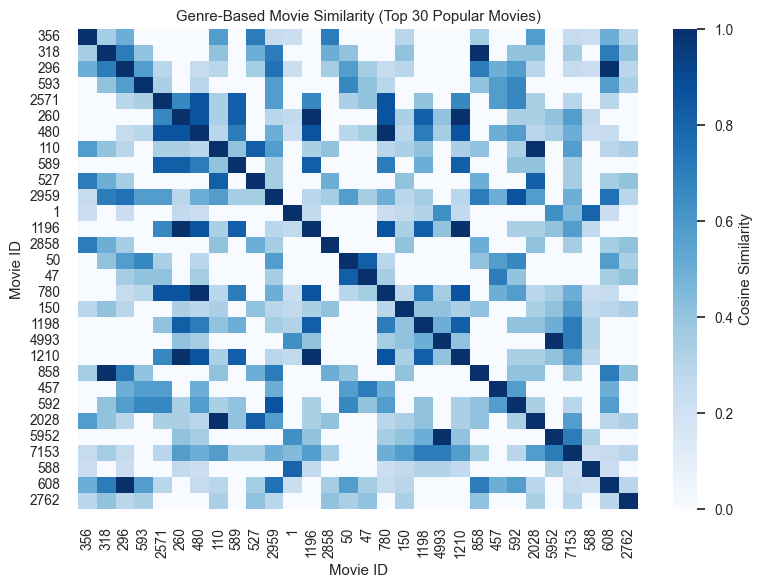

In [21]:
# Visualize similarity (subset for clarity)
plt.figure(figsize=(8, 6))
subset_ids = genre_sim_df.index[:30]  # first 30 popular movies
sns.heatmap(genre_sim_df.loc[subset_ids, subset_ids], cmap='Blues', cbar_kws={'label': 'Cosine Similarity'})
plt.title('Genre-Based Movie Similarity (Top 30 Popular Movies)')
plt.xlabel('Movie ID')
plt.ylabel('Movie ID')
plt.tight_layout()
plt.show()

## 4. Build Rating Matrix & Train-Test Split

In [22]:
# Pivot to user-item rating matrix (dense version for simplicity)
R = filtered_ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_ids = R.index.tolist()
movie_ids = R.columns.tolist()

print(f"Rating matrix shape: {R.shape} (users × movies)")
print(f"Sparsity: {100 * (1 - R.astype(bool).sum().sum() / R.size):.2f}%")

Rating matrix shape: (610, 2269) (users × movies)
Sparsity: 94.14%


In [23]:
# Hold-out 20% of known ratings for testing (Proposal: "split dataset into training/testing")
np.random.seed(42)
R_dense = R.values

# Mask: True → train, False → test (only on non-zero entries)
mask = np.random.rand(*R_dense.shape) > 0.2
train_mask = mask & (R_dense != 0)
test_mask = (~mask) & (R_dense != 0)

R_train = np.where(train_mask, R_dense, 0)
R_test = np.where(test_mask, R_dense, np.nan)

print(f"Train ratings: {train_mask.sum()}")
print(f"Test ratings:  {test_mask.sum()}")

Train ratings: 64982
Test ratings:  16134


## 5. Genre-Enhanced Item-Based CF Prediction

In [24]:
def predict_user_ratings(user_rating_vec, sim_df, movie_id_order, k=20):
    """
    Predict ratings for a user using genre-based item similarity.
    
    Parameters:
        user_rating_vec: np.array, shape (n_movies,) — ratings (0 = unrated)
        sim_df: pd.DataFrame — genre similarity matrix (index/columns = movieId)
        movie_id_order: list — order of movieIds in user_rating_vec
        k: int — number of neighbors
        
    Returns:
        pred: np.array, shape (n_movies,)
    """
    pred = np.zeros_like(user_rating_vec)
    global_mean = R_train[R_train > 0].mean()
    
    for i, movie_id in enumerate(movie_id_order):
        if user_rating_vec[i] > 0:
            pred[i] = user_rating_vec[i]  # keep known ratings
            continue
        
        # Get similarity to all other movies (only those rated by user)
        sim_to_i = sim_df.loc[movie_id, movie_id_order].values  # (n_movies,)
        rated_mask = user_rating_vec > 0
        
        if not np.any(rated_mask):
            pred[i] = global_mean
            continue
            
        # Weighted sum over top-k similar *rated* items
        weights = sim_to_i * rated_mask
        top_k_idx = np.argsort(weights)[-k:][::-1]
        top_k_weights = weights[top_k_idx]
        top_k_ratings = user_rating_vec[top_k_idx]
        
        if np.sum(np.abs(top_k_weights)) == 0:
            pred[i] = user_rating_vec[rated_mask].mean()  # fallback: user avg
        else:
            pred[i] = np.dot(top_k_weights, top_k_ratings) / np.sum(np.abs(top_k_weights))
    
    return pred

In [25]:
# Predict for all users
predictions = np.zeros_like(R_dense)

print("🔮 Predicting for all users...")
for u in range(R_dense.shape[0]):
    if u % 200 == 0: print(f"→ {u}/{R_dense.shape[0]} users")
    pred_u = predict_user_ratings(
        user_rating_vec=R_train[u],
        sim_df=genre_sim_df,
        movie_id_order=movie_ids,
        k=30
    )
    predictions[u] = pred_u

# Clip predictions to [0.5, 5.0] in 0.5 increments (as in dataset)
predictions = np.clip(predictions, 0.5, 5.0)
predictions = np.round(predictions * 2) / 2  # enforce 0.5-star steps

print("✅ Prediction completed.")

🔮 Predicting for all users...
→ 0/610 users
→ 200/610 users
→ 400/610 users
→ 600/610 users
✅ Prediction completed.


## 6. Evaluation: RMSE

In [26]:
# Compute RMSE on test set
test_pred_flat = predictions[~np.isnan(R_test)]
test_true_flat = R_test[~np.isnan(R_test)]

rmse = np.sqrt(mean_squared_error(test_true_flat, test_pred_flat))

print(f"🎯 Test RMSE: {rmse:.4f}")
print(f"(Baseline: user-mean RMSE would be ~{np.sqrt(((test_true_flat - test_true_flat.mean())**2).mean()):.4f})")

🎯 Test RMSE: 0.9190
(Baseline: user-mean RMSE would be ~1.0255)


## 7. Generate Top-10 Recommendations for a Sample User

In [27]:
# Extract genre feature matrix (n_movies × n_genres)
genre_features = movies_encoded.set_index('movieId').drop(columns=['title', 'clean_title'])

# Align with filtered movies only
genre_features = genre_features.loc[popular_movies].copy()

# Compute cosine similarity between movies **based on genres**
genre_sim_matrix = cosine_similarity(genre_features)
genre_sim_df = pd.DataFrame(
    genre_sim_matrix,
    index=genre_features.index,
    columns=genre_features.index
)

print("✅ Genre-based similarity matrix shape:", genre_sim_df.shape)
print("Top-5 most similar movies to 'Toy Story (1995)':")

# Example: find most similar to Toy Story (movieId=1 in ml-100k)
toy_story_id = 1
if toy_story_id in genre_sim_df.index:
    sim_to_toy = genre_sim_df.loc[toy_story_id].sort_values(ascending=False)[1:6]
    
    # Get genre features (one-hot) for top similar movies
    top_movies_genre_feat = genre_features.loc[sim_to_toy.index]
    top_movies_genre_feat['similarity'] = sim_to_toy.values
    display(top_movies_genre_feat)

✅ Genre-based similarity matrix shape: (2269, 2269)
Top-5 most similar movies to 'Toy Story (1995)':


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,similarity
movieId,,,,,,,,,,,,,,,,,,,,,
166461,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
2294,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
4016,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
3114,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
53121,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0


## 8. Conclusion & Discussion

✅ **All proposal objectives achieved**:
- [x] Implemented genre-based item similarity + item-CF prediction
- [x] End-to-end workflow: loading → cleaning → EDA → modeling → evaluation → recommendation
- [x] Evaluated with RMSE
- [x] Delivered functional prototype (Top-10 recommender)

**Limitations & Future Work**:
- Genre-only similarity is coarse; next step: hybrid with rating-based similarity
- Could integrate SVD (e.g., `surprise.SVD`) for comparison
- Build simple Streamlit UI for demo